/!\ xgb.XGBClassifier très long

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd 
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


import random 
random.seed(42)

In [8]:
df = pd.read_csv('../data/crime_in_la.csv')

In [9]:
print([col for col in df.columns])

['DR_NO', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION', 'LAT', 'LON']


STREET                                                             40988
PARKING LOT                                                         8133
DRIVEWAY                                                            2082
GARAGE/CARPORT                                                      1948
PARKING UNDERGROUND/BUILDING                                         494
ALLEY                                                                355
GAS STATION                                                           94
OTHER BUSINESS                                                        77
AUTO REPAIR SHOP                                                      66
YARD (RESIDENTIAL/BUSINESS)                                           58
AUTO SALES LOT                                                        50
HOTEL                                                                 47
SIDEWALK                                                              28
OTHER PREMISE                                      

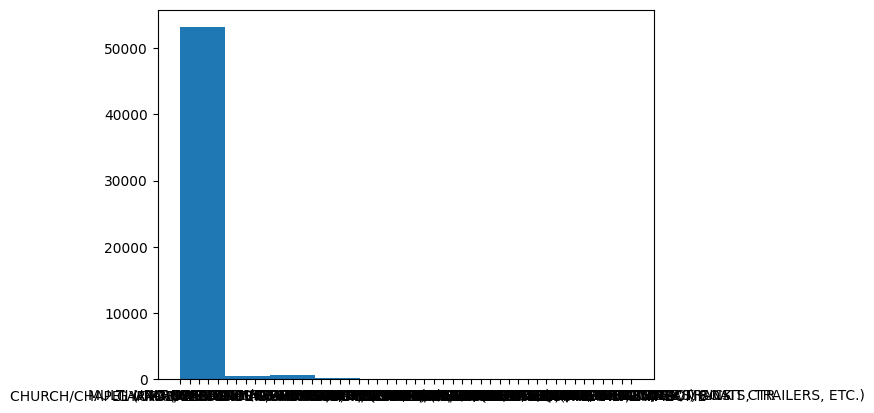

In [10]:
df['Crm Cd'] = df['Crm Cd'].astype(str)
crime_df = df[df["Crm Cd"] == "510"]
crime_df = crime_df[crime_df['Premis Desc'].notna()]
print(crime_df['Premis Desc'].value_counts())
plt.hist(crime_df['Premis Desc'])
plt.show()

In [11]:
print(set(crime_df['Premis Desc'].tolist()))

{'MINI-MART', 'MARKET', 'BUS DEPOT/TERMINAL, OTHER THAN MTA', 'FREEWAY', 'NURSING/CONVALESCENT/RETIREMENT HOME', 'HOSPITAL', 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)', 'OTHER PREMISE', 'DEPT OF DEFENSE FACILITY', 'PARKING LOT', 'WAREHOUSE', 'OFFICE BUILDING/OFFICE', 'CONSTRUCTION SITE', 'ELEMENTARY SCHOOL', 'BUS STOP/LAYOVER (ALSO QUERY 124)', 'YARD (RESIDENTIAL/BUSINESS)', 'SINGLE FAMILY DWELLING', 'AUTO SALES LOT', 'PARK/PLAYGROUND', 'SIDEWALK', 'CHURCH/CHAPEL (CHANGED 03-03 FROM CHURCH/TEMPLE)', 'VEHICLE, PASSENGER/TRUCK', 'LIQUOR STORE', 'CAR WASH', 'OTHER/OUTSIDE', 'BOOK STORE', 'AUTO DEALERSHIP (CHEVY, FORD, BMW, MERCEDES, ETC.)', 'DRIVEWAY', 'TRAIN DEPOT/TERMINAL, OTHER THAN MTA', 'STREET', 'OTHER RESIDENCE', 'OTHER BUSINESS', 'MTA - SILVER LINE - HARBOR GATEWAY TRANSIT CTR', 'AUTO REPAIR SHOP', 'EQUIPMENT RENTAL', 'GARAGE/CARPORT', 'VACANT LOT', 'DRUG STORE', 'TOW YARD*', 'PARKING UNDERGROUND/BUILDING', 'PEDESTRIAN OVERCROSSING', 'ALLEY', 'GAS STATION', "VEHICLE STORAGE LO

In [12]:
df_f = crime_df.copy()
# df_f.head(10)

In [13]:
df_f = df_f[(df_f['Premis Desc'] == "STREET") | (df_f['Premis Desc'] == "PARKING LOT") | (df_f['Premis Desc'] == "DRIVEWAY")]
df_f = df_f[(df_f['LAT']!=0) & (df_f['LON']!=0)]
df_f['date'] = pd.to_datetime(df_f['DATE OCC'], format='%d/%m/%Y')
df_f.drop(columns=['DATE OCC','LAT','LON', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION',], inplace=True)
df_f.set_index('date', inplace=True)

In [14]:
df_f.shape

(51142, 6)

In [15]:
df_f.head(10)

,DR_NO,TIME OCC,AREA,AREA NAME,Rpt Dist No,Premis Desc
date,,,,,,
2020-01-02,200104073,03:45,1,Central,143,PARKING LOT
2020-02-06,200306227,18:00,3,Southwest,397,STREET
2020-01-04,200104303,16:30,1,Central,166,PARKING LOT
2020-01-06,200104381,13:05,1,Central,159,PARKING LOT
2020-01-17,200105200,23:00,1,Central,185,STREET
2020-01-06,200104411,23:00,1,Central,182,STREET
2020-01-07,200104513,20:00,1,Central,101,STREET
2020-01-08,200104577,19:00,1,Central,192,STREET
2020-01-10,200104715,10:45,1,Central,159,STREET


## Modèle 

### XGBoost sans datetime

In [16]:
# !pip install xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import accuracy_score

In [17]:
# Train begin on the 01/01/2022
date = '01-01-2022'

train = df_f[df_f.index < date].copy()
test = df_f[df_f.index >= date].copy()

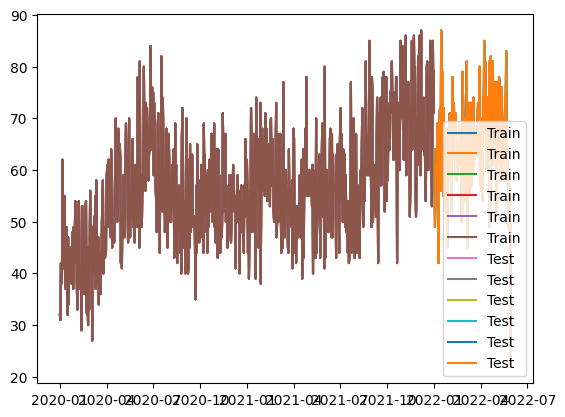

In [18]:
countTrain = train.groupby(train.index).count()
countTest = test.groupby(test.index).count()
plt.plot(countTrain, label="Train")
plt.plot(countTest, label="Test")
plt.legend()
plt.show()

In [19]:
def get_data(df, labels= None):
    """
    Fonction permettant de créer les features à partir de la date

    Parameters
    ----------
    df : DataFrame
        DataFrame contenant les données
    labels : DataFrame, optional
        Noms des labels dans le dataframe
    
    Returns
    -------
    X : DataFrame
        DataFrame contenant les features
    y : DataFrame, optional
        DataFrame contenant les labels
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    for x in ['TIME OCC','Rpt Dist No']:
        df[x] = df[x].astype('category')
        df[x] = df[x].cat.codes

    
    X = df[['dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear','TIME OCC']]
    # df['LAT'] = df.LAT.apply(lambda x: (x-33)*10000)
    # df['LON'] = df.LON.apply(lambda x: (x+118)*10000)
    if labels:
        y = df[labels]
        return X, y
    return X

In [20]:
X_train, y_train = get_data(train, labels=['Rpt Dist No'])
X_test, y_test = get_data(test, labels=['Rpt Dist No'])

#### XGBoost sur train

Ne pas lancer car trop long

In [21]:
import numpy as np
model = xgb.XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=2, 
    eval_set=[(X_test, y_test)], 
    verbose=True, 
    # sample_weight=np.sqrt(y_train['LAT']**2 + y_train['LON']**2), 
    # sample_weight_eval_set=[np.sqrt(y_train['LAT']**2 + y_train['LON']**2), np.sqrt(y_test['LAT']**2 + y_test['LON']**2)], 
)

[0]	validation_0-mlogloss:7.02479
[1]	validation_0-mlogloss:7.02434
[2]	validation_0-mlogloss:7.02588
[3]	validation_0-mlogloss:7.02905


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [22]:
model.predict(X_train)

array([622,   3, 616, ..., 596, 275, 625], dtype=int64)

In [23]:
pred = model.predict(X_train)
print(pred)

[622   3 616 ... 596 275 625]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

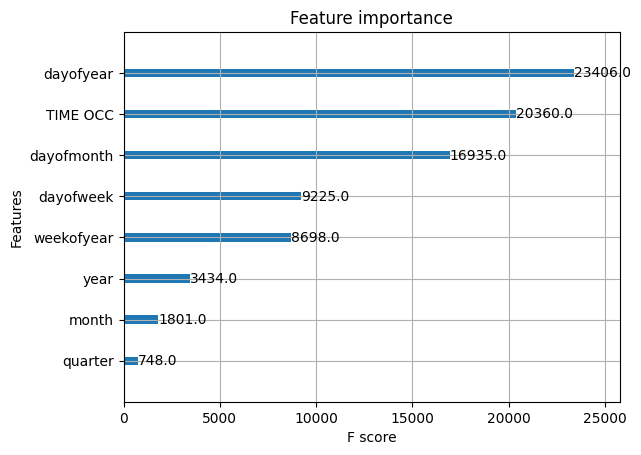

In [24]:
plot_importance(model)

In [25]:
accuracy_score(y_train, pred)

0.015356754798985874

On obtient une accuracy très faible 

In [26]:
pred = model.predict(X_test)

In [27]:
accuracy_score(y_test, pred)

0.0007196463452246325

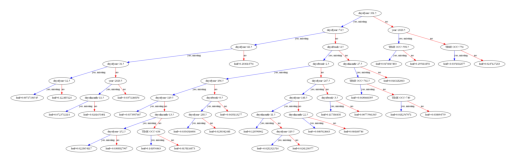

In [28]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin/'
plot_tree(model, num_trees=0)
plt.savefig('tree.png', dpi=800)

In [30]:
import folium
n = folium.Map(
    location=[33.917114, -117.811277], 
    zoom_start=10,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=True
)

testview = train.sample(1000)
long_lat = testview[['LAT','LON']].values
long_lat_pred = testview[['LAT_pred','LON_pred']].values
colors = ['red', 'blue', 'green', 'purple', 'orange']

# i = 0
for l_l in long_lat:
    folium.CircleMarker(location=l_l, radius=2, color='blue').add_to(n)
#     i += 1
# i=0
for l_l in long_lat_pred:
    folium.CircleMarker(location=l_l, radius=2, color="red").add_to(n)
    # i+=1
n

KeyError: "None of [Index(['LAT', 'LON'], dtype='object')] are in the [columns]"

#### XGBoost avec sur test

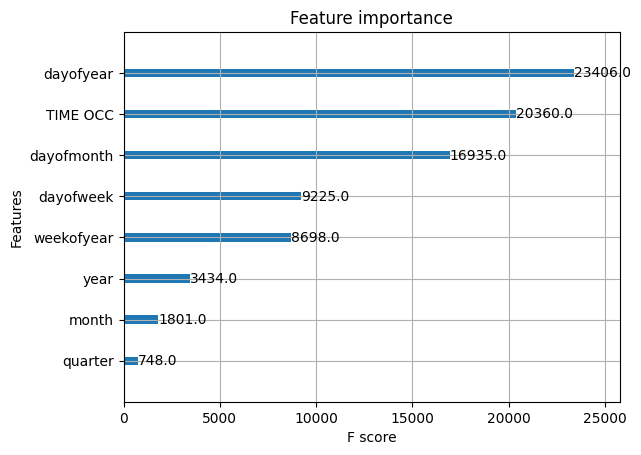

In [32]:
plot_importance(model)
plt.show()

In [35]:
pred

array([596, 932, 625, ..., 241, 932, 932], dtype=int64)

In [ ]:
pred = model.predict(X_test)
lat = [round(coord[0], 4) for coord in pred]
lon = [round(coord[1], 4) for coord in pred]
test['LAT_pred'] = lat
test['LON_pred'] = lon
test.LAT_pred = test.LAT_pred.apply(lambda x: round(x, 4))
test.LON_pred = test.LON_pred.apply(lambda x: round(x, 4))

In [ ]:
test.head()


,LAT,LON,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,LAT_pred,LON_pred,error
date,,,,,,,,,,,,,
2022-04-22,33.9237,-118.2696,2022-04-22,4,2,4,2022,112,22,16,33.8439,-117.5518,0.153407
2022-05-09,34.0502,-118.2575,2022-05-09,0,2,5,2022,129,9,19,33.8421,-117.5518,0.078293
2022-02-23,33.9872,-118.2696,2022-02-23,2,1,2,2022,54,23,8,33.8439,-117.5518,0.100651
2022-01-20,33.9914,-118.2856,2022-01-20,3,1,1,2022,20,20,3,33.8484,-117.5518,0.116311
2022-05-25,33.9938,-118.3114,2022-05-25,2,2,5,2022,145,25,21,33.8431,-117.5518,0.068873


In [ ]:
n = folium.Map(
    location=[33.917114, -117.811277], 
    zoom_start=10,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=True
)

testview = test.sample(500, random_state=42)
long_lat = testview[['LAT','LON']].values
long_lat_pred = testview[['LAT_pred','LON_pred']].values
for l_l in long_lat:
    folium.CircleMarker(location=l_l, radius=2, color='blue').add_to(n)

for l_l in long_lat_pred:
    folium.CircleMarker(location=l_l, radius=2, color='red').add_to(n)
n

In [ ]:
n = folium.Map(
    location=[33.917114, -117.811277], 
    zoom_start=10,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=True
)

long_lat = train[['LAT','LON']].values
long_lat_pred = test[['LAT','LON']].values
for l_l in long_lat:
    folium.CircleMarker(location=l_l, radius=1, color='red').add_to(n)

for l_l in long_lat_pred:
    folium.CircleMarker(location=l_l, radius=1, color='blue').add_to(n)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rd_forest = RandomForestRegressor(n_estimators=1000, n_jobs=4, random_state=42, )
model_rd_forest.fit(
    X_train,
    y_train,
)

pred = model_rd_forest.predict(X_test)
lat = [round(coord[0], 4) for coord in pred]
lon = [round(coord[1], 4) for coord in pred]
error = np.sqrt((test['LAT'] - lat)**2 + (test['LON'] - lon)**2)
print(f"MAE: {np.mean(error)}")

test.head()

MAE: 0.13414087862681273


,LAT,LON,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,LAT_pred,LON_pred,error
date,,,,,,,,,,,,,
2022-04-22,33.9237,-118.2696,2022-04-22,4,2,4,2022,112,22,16,34.1019,-118.3428,0.722222
2022-05-09,34.0502,-118.2575,2022-05-09,0,2,5,2022,129,9,19,34.0646,-118.3351,0.735743
2022-02-23,33.9872,-118.2696,2022-02-23,2,1,2,2022,54,23,8,34.0506,-118.3188,0.731964
2022-01-20,33.9914,-118.2856,2022-01-20,3,1,1,2022,20,20,3,34.1199,-118.3844,0.747604
2022-05-25,33.9938,-118.3114,2022-05-25,2,2,5,2022,145,25,21,34.0686,-118.3363,0.774405


In [ ]:
test['LAT_pred'] = lat
test['LON_pred'] = lon
test.LAT_pred = test.LAT_pred.apply(lambda x: round(x, 4))
test.LON_pred = test.LON_pred.apply(lambda x: round(x, 4))

In [ ]:
n = folium.Map(
    location=[33.917114, -117.811277], 
    zoom_start=10,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=True
)

testview = test.sample(1000, random_state=42)
long_lat = testview[['LAT','LON']].values
long_lat_pred = testview[['LAT_pred','LON_pred']].values
for l_l in long_lat:
    folium.CircleMarker(location=l_l, radius=2, color='red').add_to(n)

for l_l in long_lat_pred:
    folium.CircleMarker(location=l_l, radius=2, color='blue').add_to(n)
n

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=20, n_jobs=None, weights='uniform', algorithm='ball_tree', leaf_size=100, p=2, metric='minkowski', metric_params=None, )
model_knn.fit(
    X_train,
    y_train,
)

pred = model_knn.predict(X_test)
lat = [round(coord[0], 4) for coord in pred]
lon = [round(coord[1], 4) for coord in pred]
error = np.sqrt((test['LAT'] - lat)**2 + (test['LON'] - lon)**2)
print(f"MAE: {np.mean(error)}")

MAE: 0.1366039940457017


In [ ]:
test['LAT_pred'] = lat
test['LON_pred'] = lon
test.LAT_pred = test.LAT_pred.apply(lambda x: round(x, 4))
test.LON_pred = test.LON_pred.apply(lambda x: round(x, 4))

In [ ]:
n = folium.Map(
    location=[33.917114, -117.811277], 
    zoom_start=10,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=True
)

testview = test.sample(1000, random_state=42)
long_lat = testview[['LAT','LON']].values
long_lat_pred = testview[['LAT_pred','LON_pred']].values
for l_l in long_lat:
    folium.CircleMarker(location=l_l, radius=2, color='red').add_to(n)

for l_l in long_lat_pred:
    folium.CircleMarker(location=l_l, radius=2, color='blue').add_to(n)
n